In [2]:
import pandas as pd
import numpy as np
import time
import joblib
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from scipy.stats import skew, kurtosis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from tabulate import tabulate
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from scikeras.wrappers import KerasClassifier
import gc
import keras_tuner
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

In [3]:
#### CASE1- The number of legitimate traffic have been reduced to balance the dataset ####

In [4]:
df= pd.read_csv('df_reduced.csv', low_memory=False) #Loading the dataset

In [5]:
######################## Preprocessing & EDA PART ##################################

In [6]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330936 entries, 0 to 330935
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   tcp.flags                   330936 non-null  object 
 1   tcp.time_delta              330936 non-null  float64
 2   tcp.len                     330936 non-null  int64  
 3   mqtt.conack.flags           330936 non-null  object 
 4   mqtt.conack.flags.reserved  330936 non-null  float64
 5   mqtt.conack.flags.sp        330936 non-null  float64
 6   mqtt.conack.val             330936 non-null  float64
 7   mqtt.conflag.cleansess      330936 non-null  float64
 8   mqtt.conflag.passwd         330936 non-null  float64
 9   mqtt.conflag.qos            330936 non-null  float64
 10  mqtt.conflag.reserved       330936 non-null  float64
 11  mqtt.conflag.retain         330936 non-null  float64
 12  mqtt.conflag.uname          330936 non-null  float64
 13  mqtt.conflag.w

In [7]:
# Basic information
# The dataset has
         #330936 total entries 
         #34 columns
        #Column data types : 2 integers, 26 floats, 6 objects


In [8]:
df.head()

,tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.flags.reserved,mqtt.conack.flags.sp,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.qos,...,mqtt.qos,mqtt.retain,mqtt.sub.qos,mqtt.suback.qos,mqtt.ver,mqtt.willmsg,mqtt.willmsg_len,mqtt.willtopic,mqtt.willtopic_len,is_attack
0,0x00000018,0.998867,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0x00000010,0.000067,1460,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0x00000010,0.000058,1460,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0x00000018,0.000227,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0x00000018,0.000236,16,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [9]:
missing_data = df.isnull().sum() # Checking missing values
print("Missing data:")
print(missing_data)

Missing data:
tcp.flags                     0
tcp.time_delta                0
tcp.len                       0
mqtt.conack.flags             0
mqtt.conack.flags.reserved    0
mqtt.conack.flags.sp          0
mqtt.conack.val               0
mqtt.conflag.cleansess        0
mqtt.conflag.passwd           0
mqtt.conflag.qos              0
mqtt.conflag.reserved         0
mqtt.conflag.retain           0
mqtt.conflag.uname            0
mqtt.conflag.willflag         0
mqtt.conflags                 0
mqtt.dupflag                  0
mqtt.hdrflags                 0
mqtt.kalive                   0
mqtt.len                      0
mqtt.msg                      0
mqtt.msgid                    0
mqtt.msgtype                  0
mqtt.proto_len                0
mqtt.protoname                0
mqtt.qos                      0
mqtt.retain                   0
mqtt.sub.qos                  0
mqtt.suback.qos               0
mqtt.ver                      0
mqtt.willmsg                  0
mqtt.willmsg_len          

In [10]:
### There are no missing values 

In [11]:
df.describe()

,tcp.time_delta,tcp.len,mqtt.conack.flags.reserved,mqtt.conack.flags.sp,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.qos,mqtt.conflag.reserved,mqtt.conflag.retain,...,mqtt.qos,mqtt.retain,mqtt.sub.qos,mqtt.suback.qos,mqtt.ver,mqtt.willmsg,mqtt.willmsg_len,mqtt.willtopic,mqtt.willtopic_len,is_attack
count,330936.000000,330936.000000,330936.0,330936.0,330936.000000,330936.000000,330936.000000,330936.0,330936.0,330936.0,...,330936.000000,330936.000000,330936.0,330936.0,330936.000000,330936.0,330936.0,330936.0,330936.0,330936.000000
mean,0.271595,152.566862,0.0,0.0,0.021575,0.009917,0.004297,0.0,0.0,0.0,...,0.164476,0.000366,0.0,0.0,0.039669,0.0,0.0,0.0,0.0,0.500015
std,2.835911,945.491750,0.0,0.0,0.327736,0.099091,0.065410,0.0,0.0,0.0,...,0.370707,0.019118,0.0,0.0,0.396364,0.0,0.0,0.0,0.0,0.500001
min,-0.000002,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
25%,0.000003,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
50%,0.000026,10.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000
75%,0.000169,14.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000
max,60.000878,32768.000000,0.0,0.0,5.000000,1.000000,1.000000,0.0,0.0,0.0,...,1.000000,1.000000,0.0,0.0,4.000000,0.0,0.0,0.0,0.0,1.000000


In [12]:
#### From the description table , there are columns with zero mean and zero standard deviation (std).
### Hence, it indicates that these columns are constant or have very little variation,
### then we can conclude  that they do not provide useful information for predictive modeling
### Thus, we will print all columns with zero mean and zero std , and subsquently drop them 

In [13]:
description = df.describe()
zero_mean = description.loc['mean'] == 0
zero_std  = description.loc['std'] == 0
columns_with_zero_mean_and_zero_std = description.columns[zero_mean & zero_std]
print(columns_with_zero_mean_and_zero_std)
print (f"Total number of constant columns is :{len(columns_with_zero_mean_and_zero_std)}")


Index(['mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp',
       'mqtt.conflag.qos', 'mqtt.conflag.reserved', 'mqtt.conflag.retain',
       'mqtt.conflag.willflag', 'mqtt.sub.qos', 'mqtt.suback.qos',
       'mqtt.willmsg', 'mqtt.willmsg_len', 'mqtt.willtopic',
       'mqtt.willtopic_len'],
      dtype='object')
Total number of constant columns is :12


In [14]:
### There are 12 constant columns in total, 
### Dropping them , we remain with 22 features in total 

In [15]:
df2 = df.drop(columns=columns_with_zero_mean_and_zero_std) # Dropping the constant columns and forming new dataframe

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330936 entries, 0 to 330935
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   tcp.flags               330936 non-null  object 
 1   tcp.time_delta          330936 non-null  float64
 2   tcp.len                 330936 non-null  int64  
 3   mqtt.conack.flags       330936 non-null  object 
 4   mqtt.conack.val         330936 non-null  float64
 5   mqtt.conflag.cleansess  330936 non-null  float64
 6   mqtt.conflag.passwd     330936 non-null  float64
 7   mqtt.conflag.uname      330936 non-null  float64
 8   mqtt.conflags           330936 non-null  object 
 9   mqtt.dupflag            330936 non-null  float64
 10  mqtt.hdrflags           330936 non-null  object 
 11  mqtt.kalive             330936 non-null  float64
 12  mqtt.len                330936 non-null  float64
 13  mqtt.msg                330936 non-null  object 
 14  mqtt.msgid          

In [17]:
###Checking the target column "is_attack"
# The columnis binary, and highlight the type of traffic , legitimate (0) vs malicous or attacks (1)

In [18]:
column = 'is_attack'
mean = df2[column].mean()
std = df2[column].std()
print (f"{column} mean is :{mean}" )
print (f"{column} std is :{std}" )     

is_attack mean is :0.5000151086614935
is_attack std is :0.5000007552061367


In [19]:
### A mean of 0.5...,suggest that ~ 50% of the traffic instances in the dataset are attack traffic.
### This is a sign that the dataset is a balanced dataset, with attack traffic approximately to legitimate 
### The std which measure the amount of variation in the coulmn also confirm that the dataset is balanced 

In [20]:
#Visualizing the distribution of the traffic 

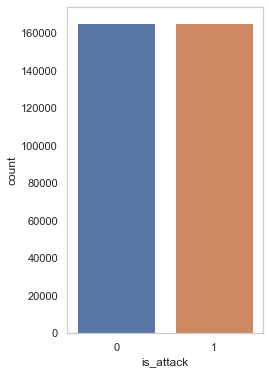

In [21]:
total = len(df2)
counts = df2['is_attack'].value_counts()
percentages = counts / total * 100
plt.rcParams['font.family'] = 'Times New Roman'
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(3.5, 6))
ax = sns.countplot(x=df2['is_attack'])
plt.grid(False)
path = '/Users/A/Documents/TEP/Figures/4-TrafficdistributionBinary.png'
plt.savefig(path, bbox_inches='tight')

In [22]:
### Categorical vs Numerical features 

In [23]:
cat_cols= df2.select_dtypes(include=['object']).columns
num_cols = df2.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index(['tcp.flags', 'mqtt.conack.flags', 'mqtt.conflags', 'mqtt.hdrflags',
       'mqtt.msg', 'mqtt.protoname'],
      dtype='object')
Numerical Variables:
['tcp.time_delta', 'tcp.len', 'mqtt.conack.val', 'mqtt.conflag.cleansess', 'mqtt.conflag.passwd', 'mqtt.conflag.uname', 'mqtt.dupflag', 'mqtt.kalive', 'mqtt.len', 'mqtt.msgid', 'mqtt.msgtype', 'mqtt.proto_len', 'mqtt.qos', 'mqtt.retain', 'mqtt.ver', 'is_attack']


In [24]:
df2.head()

,tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.uname,mqtt.conflags,mqtt.dupflag,...,mqtt.len,mqtt.msg,mqtt.msgid,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.qos,mqtt.retain,mqtt.ver,is_attack
0,0x00000018,0.998867,10,0,0.0,0.0,0.0,0.0,0,0.0,...,8.0,32,0.0,3.0,0.0,0,0.0,0.0,0.0,0
1,0x00000010,0.000067,1460,0,0.0,0.0,0.0,0.0,0,0.0,...,169.0,6361653943666144654266454162444634326230633041...,2714.0,3.0,0.0,0,1.0,0.0,0.0,1
2,0x00000010,0.000058,1460,0,0.0,0.0,0.0,0.0,0,0.0,...,163.0,4232646141394333463334613232626446326646383446...,1548.0,3.0,0.0,0,1.0,0.0,0.0,1
3,0x00000018,0.000227,10,0,0.0,0.0,0.0,0.0,0,0.0,...,8.0,32,0.0,3.0,0.0,0,0.0,0.0,0.0,0
4,0x00000018,0.000236,16,0,0.0,0.0,0.0,0.0,0,0.0,...,2.0,0,2800.0,4.0,0.0,0,0.0,0.0,0.0,1


In [25]:
### Encoding the categorical cols ####

In [26]:
#encoder = OneHotEncoder(sparse=False, drop='first') # Initializing OneHotEncoder
#encoded_data = encoder.fit_transform(df2[cat_cols]) # Fit and transform the categorical cols

#encoded_col_names = encoder.get_feature_names_out(cat_cols) # Get the new column names from the encoder

#df3 = pd.DataFrame(encoded_data, columns=encoded_col_names) # Creating a df with the encoded columns'''


In [27]:
#### Insufficient memory problem while encoding,######
#MemoryError: Unable to allocate 4.43 TiB for an array with shape (12081189, 50437) and data type float64

In [28]:
# Categorical Variables: Index(['tcp.flags', 'mqtt.conack.flags', 'mqtt.conflags', 'mqtt.hdrflags'] contain hexadecimal string 
# we convert this string to decinmal to make them numerical
      

In [29]:
def hex_to_int(value): # Function to convert hexadecimal string to integer
    if isinstance(value, str) and value.startswith('0x'):
        return int(value, 16)
    else:
        return int(value)
    
columns_to_convert = ['tcp.flags', 'mqtt.conack.flags', 'mqtt.conflags', 'mqtt.hdrflags']

df3 = df2.copy() # Creating a copy of df2 for df3

for col in columns_to_convert:
    df3[col] = df3[col].apply(hex_to_int)

In [30]:
cat_cols= df3.select_dtypes(include=['object']).columns
num_cols = df3.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index(['mqtt.msg', 'mqtt.protoname'], dtype='object')
Numerical Variables:
['tcp.flags', 'tcp.time_delta', 'tcp.len', 'mqtt.conack.flags', 'mqtt.conack.val', 'mqtt.conflag.cleansess', 'mqtt.conflag.passwd', 'mqtt.conflag.uname', 'mqtt.conflags', 'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.kalive', 'mqtt.len', 'mqtt.msgid', 'mqtt.msgtype', 'mqtt.proto_len', 'mqtt.qos', 'mqtt.retain', 'mqtt.ver', 'is_attack']


In [31]:
protoname_counts = df3['mqtt.protoname'].value_counts()
print("\nValue counts of mqtt.protoname:")
print(protoname_counts)


Value counts of mqtt.protoname:
0       327654
MQTT      3282
Name: mqtt.protoname, dtype: int64


In [32]:
MQTTmsg_counts = df3['mqtt.msg'].value_counts()
print("\nValue counts of mqtt.msg:")
print(MQTTmsg_counts)


Value counts of mqtt.msg:
0                                                                                                                                                                                                                           163722
30                                                                                                                                                                                                                           38636
31                                                                                                                                                                                                                           22571
32                                                                                                                                                                                                                           22194
0.0                                                              

In [33]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330936 entries, 0 to 330935
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   tcp.flags               330936 non-null  int64  
 1   tcp.time_delta          330936 non-null  float64
 2   tcp.len                 330936 non-null  int64  
 3   mqtt.conack.flags       330936 non-null  int64  
 4   mqtt.conack.val         330936 non-null  float64
 5   mqtt.conflag.cleansess  330936 non-null  float64
 6   mqtt.conflag.passwd     330936 non-null  float64
 7   mqtt.conflag.uname      330936 non-null  float64
 8   mqtt.conflags           330936 non-null  int64  
 9   mqtt.dupflag            330936 non-null  float64
 10  mqtt.hdrflags           330936 non-null  int64  
 11  mqtt.kalive             330936 non-null  float64
 12  mqtt.len                330936 non-null  float64
 13  mqtt.msg                330936 non-null  object 
 14  mqtt.msgid          

In [34]:
df4 = df3.copy()
df4.loc[df4['mqtt.protoname'] == 'MQTT', 'mqtt.protoname'] = 1 #replacing 'MQTT' with "1"
df4['mqtt.protoname'] = pd.to_numeric(df4['mqtt.protoname'], errors='coerce') #Converting to numerical

In [35]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330936 entries, 0 to 330935
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   tcp.flags               330936 non-null  int64  
 1   tcp.time_delta          330936 non-null  float64
 2   tcp.len                 330936 non-null  int64  
 3   mqtt.conack.flags       330936 non-null  int64  
 4   mqtt.conack.val         330936 non-null  float64
 5   mqtt.conflag.cleansess  330936 non-null  float64
 6   mqtt.conflag.passwd     330936 non-null  float64
 7   mqtt.conflag.uname      330936 non-null  float64
 8   mqtt.conflags           330936 non-null  int64  
 9   mqtt.dupflag            330936 non-null  float64
 10  mqtt.hdrflags           330936 non-null  int64  
 11  mqtt.kalive             330936 non-null  float64
 12  mqtt.len                330936 non-null  float64
 13  mqtt.msg                330936 non-null  object 
 14  mqtt.msgid          

In [36]:
cat_cols= df4.select_dtypes(include=['object']).columns
num_cols = df4.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index(['mqtt.msg'], dtype='object')
Numerical Variables:
['tcp.flags', 'tcp.time_delta', 'tcp.len', 'mqtt.conack.flags', 'mqtt.conack.val', 'mqtt.conflag.cleansess', 'mqtt.conflag.passwd', 'mqtt.conflag.uname', 'mqtt.conflags', 'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.kalive', 'mqtt.len', 'mqtt.msgid', 'mqtt.msgtype', 'mqtt.proto_len', 'mqtt.protoname', 'mqtt.qos', 'mqtt.retain', 'mqtt.ver', 'is_attack']


In [37]:
df4.head()

,tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.uname,mqtt.conflags,mqtt.dupflag,...,mqtt.len,mqtt.msg,mqtt.msgid,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.qos,mqtt.retain,mqtt.ver,is_attack
0,24,0.998867,10,0,0.0,0.0,0.0,0.0,0,0.0,...,8.0,32,0.0,3.0,0.0,0,0.0,0.0,0.0,0
1,16,0.000067,1460,0,0.0,0.0,0.0,0.0,0,0.0,...,169.0,6361653943666144654266454162444634326230633041...,2714.0,3.0,0.0,0,1.0,0.0,0.0,1
2,16,0.000058,1460,0,0.0,0.0,0.0,0.0,0,0.0,...,163.0,4232646141394333463334613232626446326646383446...,1548.0,3.0,0.0,0,1.0,0.0,0.0,1
3,24,0.000227,10,0,0.0,0.0,0.0,0.0,0,0.0,...,8.0,32,0.0,3.0,0.0,0,0.0,0.0,0.0,0
4,24,0.000236,16,0,0.0,0.0,0.0,0.0,0,0.0,...,2.0,0,2800.0,4.0,0.0,0,0.0,0.0,0.0,1


In [38]:
df5 = df4.drop(columns=['mqtt.msg']) # very large values, hence an outlier 

# Separating the data based on the target variable
df5_normal = df5[df5['is_attack'] == 0]
df5_attack = df5[df5['is_attack'] == 1]
    
def calculate_statistics(df5):    # Function to calculate statistical characteristics
    num_cols_2 = df5.select_dtypes(include=np.number).columns.tolist()
    if 'is_attack' in num_cols_2:
        num_cols_2.remove('is_attack')  #isolating target column
    stats = pd.DataFrame()
    stats['mean'] = df5[num_cols_2].mean()
    stats['std'] = df5[num_cols_2].std()
    stats['skewness'] = df5[num_cols_2].apply(lambda x: skew(x.dropna()))
    stats['kurtosis'] = df5[num_cols_2].apply(lambda x: kurtosis(x.dropna()))
    return stats

# Calculating statistics for normal and attack data
normal_stats = calculate_statistics(df5_normal)
attack_stats = calculate_statistics(df5_attack)

stats_diff = abs(normal_stats - attack_stats) # The difference in statistics

stats_diff['sum_diff'] = stats_diff.sum(axis=1) # Sum of differences for each feature

threshold = 200  # Defining threshold for feature selection

# Selecting the features with sum of differences above the threshold
significant_features = stats_diff[stats_diff['sum_diff'] > threshold].index.tolist()
df_significant = df5[significant_features + ['is_attack']]

In [39]:
print(df5.columns)

Index(['tcp.flags', 'tcp.time_delta', 'tcp.len', 'mqtt.conack.flags',
       'mqtt.conack.val', 'mqtt.conflag.cleansess', 'mqtt.conflag.passwd',
       'mqtt.conflag.uname', 'mqtt.conflags', 'mqtt.dupflag', 'mqtt.hdrflags',
       'mqtt.kalive', 'mqtt.len', 'mqtt.msgid', 'mqtt.msgtype',
       'mqtt.proto_len', 'mqtt.protoname', 'mqtt.qos', 'mqtt.retain',
       'mqtt.ver', 'is_attack'],
      dtype='object')


In [40]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330936 entries, 0 to 330935
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   tcp.flags               330936 non-null  int64  
 1   tcp.time_delta          330936 non-null  float64
 2   tcp.len                 330936 non-null  int64  
 3   mqtt.conack.flags       330936 non-null  int64  
 4   mqtt.conack.val         330936 non-null  float64
 5   mqtt.conflag.cleansess  330936 non-null  float64
 6   mqtt.conflag.passwd     330936 non-null  float64
 7   mqtt.conflag.uname      330936 non-null  float64
 8   mqtt.conflags           330936 non-null  int64  
 9   mqtt.dupflag            330936 non-null  float64
 10  mqtt.hdrflags           330936 non-null  int64  
 11  mqtt.kalive             330936 non-null  float64
 12  mqtt.len                330936 non-null  float64
 13  mqtt.msgid              330936 non-null  float64
 14  mqtt.msgtype        

In [41]:
stats = calculate_statistics(df5)
print(stats)

                               mean          std   skewness     kurtosis
tcp.flags                 20.278906     4.474610  -0.967318     1.291809
tcp.time_delta             0.271595     2.835911  20.269241   415.634187
tcp.len                  152.566862   945.491750  28.063691   937.082640
mqtt.conack.flags          0.000000     0.000000   0.000000    -3.000000
mqtt.conack.val            0.021575     0.327736  15.124557   226.752233
mqtt.conflag.cleansess     0.009917     0.099091   9.891595    95.843655
mqtt.conflag.passwd        0.004297     0.065410  15.156848   227.730054
mqtt.conflag.uname         0.004309     0.065501  15.135298   227.077259
mqtt.conflags              0.846387    12.697601  15.137627   227.211502
mqtt.dupflag               0.056528     0.230938   3.840626    12.750405
mqtt.hdrflags             33.493760    30.141838   1.173012     5.984471
mqtt.kalive              201.608529  3625.591571  17.964557   320.726037
mqtt.len                  31.703039    61.542514   

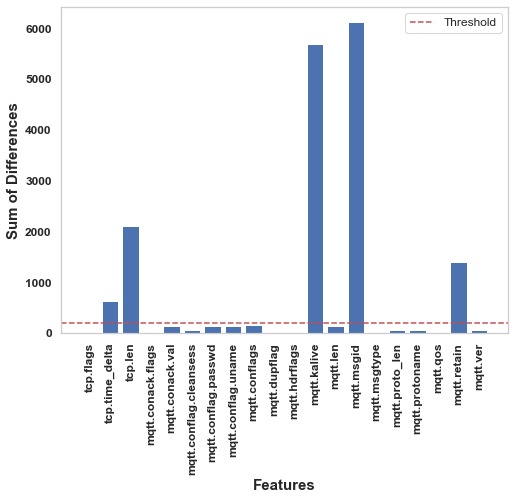

In [53]:
plt.figure(figsize=(8, 6))
plt.bar(stats_diff.index, stats_diff['sum_diff'])
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Features', fontsize=15, fontweight='bold') 
plt.ylabel('Sum of Differences', fontsize=15,fontweight='bold') 
plt.xticks(rotation=90, fontsize=12, fontweight='bold') 
plt.yticks(fontsize=12, fontweight='bold')  
plt.legend(fontsize=12) 
plt.grid(False)
path = '/Users/A/Documents/TEP/Figures/DPI/Trafficsumdifference.png'
plt.savefig(path, bbox_inches='tight', dpi=300)
plt.show()

In [43]:
df_significant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330936 entries, 0 to 330935
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tcp.time_delta  330936 non-null  float64
 1   tcp.len         330936 non-null  int64  
 2   mqtt.kalive     330936 non-null  float64
 3   mqtt.msgid      330936 non-null  float64
 4   mqtt.retain     330936 non-null  float64
 5   is_attack       330936 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 15.1 MB


In [44]:
df_significant.head()

,tcp.time_delta,tcp.len,mqtt.kalive,mqtt.msgid,mqtt.retain,is_attack
0,0.998867,10,0.0,0.0,0.0,0
1,0.000067,1460,0.0,2714.0,0.0,1
2,0.000058,1460,0.0,1548.0,0.0,1
3,0.000227,10,0.0,0.0,0.0,0
4,0.000236,16,0.0,2800.0,0.0,1


In [45]:
df_significant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330936 entries, 0 to 330935
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tcp.time_delta  330936 non-null  float64
 1   tcp.len         330936 non-null  int64  
 2   mqtt.kalive     330936 non-null  float64
 3   mqtt.msgid      330936 non-null  float64
 4   mqtt.retain     330936 non-null  float64
 5   is_attack       330936 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 15.1 MB


In [46]:
df_significant.to_csv("dfs2.csv", index=False)

In [49]:
             ######################## TRAINING AND TESTING PART ##################################

In [54]:
X = df_significant.drop(columns=['is_attack']) # separating the data into features and target
y = df_significant['is_attack']

#Scaling features 
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Splitting the data 


In [55]:
                    ##---------------1-- Random Forest Classifier -----------------##

In [51]:

########################################
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}
#########################################

rf_model = RandomForestClassifier(random_state=42) 

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2) # Initializing GridSearchCV

start_time = time.time() # Training start time
grid_search.fit(X_train, y_train) # Fitting GridSearchCV
end_time = time.time() # Training end time

####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")

best_rf_model = grid_search.best_estimator_ # Getting the best model from GridSearchCV
######################################################
test_start_time = time.time() # Testing start time

y_pred_rf = best_rf_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing end time
########################################################

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

# Best parameters#
print("Best parameters found: ", grid_search.best_params_)

# Best estimator
print("Best estimator: ", grid_search.best_estimator_)

########################################################

# Model Evaluation Metrics

print("accuracy")
print(accuracy_score(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

#####################################################################
# Accessing the results of cross-validation

cv_results = grid_search.cv_results_

# Extracting and printing the relevant information
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']
params = cv_results['params']

print("Cross-validation results:")
for mean, std, param in zip(mean_test_scores, std_test_scores, params):
    print(f"Mean test score: {mean:.3f}, Std test score: {std:.3f}, Parameters: {param}")


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\A\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
298 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\A\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\A\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\A\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_cons

The training took 1427.71 seconds
The testing took 0.43 seconds
Best parameters found:  {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best estimator:  RandomForestClassifier(random_state=42)
accuracy
0.9520452050241235

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     49639
           1       0.98      0.92      0.95     49642

    accuracy                           0.95     99281
   macro avg       0.95      0.95      0.95     99281
weighted avg       0.95      0.95      0.95     99281


Confusion Matrix:
[[48619  1020]
 [ 3741 45901]]
Cross-validation results:
Mean test score: nan, Std test score: nan, Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean test score: nan, Std test score: nan, Parameters: {'bootstrap': True, 'crit

In [ ]:
#Training RF model with best found parameters

In [56]:
b_rf_model = RandomForestClassifier(
    bootstrap=True,
    criterion='gini',
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

start_time = time.time() # Training start time
b_rf_model.fit(X_train, y_train) #Training
end_time = time.time() # Training end time

####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")

######################################################
test_start_time = time.time() # Testing start time

y_pred_brf = b_rf_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing start time
########################################################

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

print("Accuracy:", accuracy_score(y_test, y_pred_brf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_brf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_brf))

The training took 8.03 seconds
The testing took 0.51 seconds
Accuracy: 0.9520452050241235

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     49639
           1       0.98      0.92      0.95     49642

    accuracy                           0.95     99281
   macro avg       0.95      0.95      0.95     99281
weighted avg       0.95      0.95      0.95     99281


Confusion Matrix:
[[48619  1020]
 [ 3741 45901]]


In [49]:
#Area Under the Curve (AUC)/ Area Under the Receiver Operating Characteristic (ROC) Curve

ROC AUC: 0.99


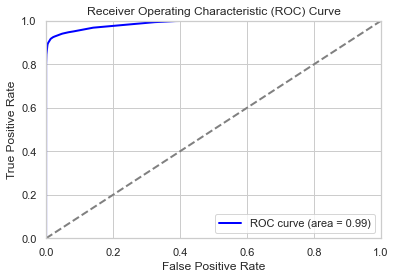

In [58]:
y_prob_rf = b_rf_model.predict_proba(X_test)[:, 1] # Predicting probabilities for the positive class

# Computing ROC AUC
roc_auc = roc_auc_score(y_test, y_prob_rf)
print(f'ROC AUC: {roc_auc:.2f}')

# Computing ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

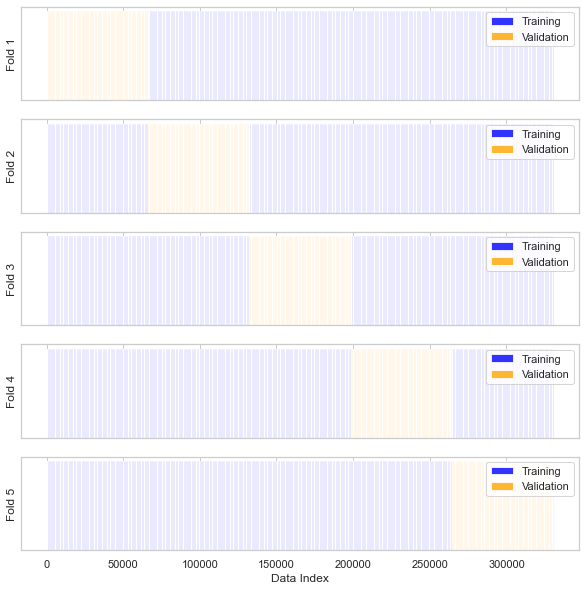

In [105]:
# plotting K-Fold cross-validation
def plot_kfold_cv(df_significant, K):
    fig, ax = plt.subplots(K, 1, figsize=(10, K * 2), sharex=True)
    
    X = df_significant.drop(columns=['is_attack']).values
    y = df_significant['is_attack'].values
    kf = KFold(n_splits=K)
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        ax[i].bar(train_index, np.ones_like(train_index), color='blue', alpha=0.8, label='Training')
        ax[i].bar(test_index, np.ones_like(test_index), color='orange', alpha=0.8, label='Validation')
        
        ax[i].set_ylabel(f'Fold {i+1}')
        ax[i].set_yticks([])
        ax[i].legend(loc='upper right')
        
    ax[K - 1].set_xlabel('Data Index')
    path = '/Users/A/Documents/TEP/Figures/K-fold validation.png'
    plt.savefig(path, bbox_inches='tight')
    plt.show()
plot_kfold_cv(df_significant, K)


In [51]:
 ##---------------2--LOGISTIC REGRESSION -----------------##

In [105]:

########################################
lr_param_grid = {
     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'max_iter': [100, 200, 300],
     'tol': [1e-4, 1e-3, 1e-2],
     'fit_intercept': [True, False]
}
#########################################


lr_model=LogisticRegression(class_weight='balanced')

lr_grid_search = GridSearchCV(lr_model, param_grid=lr_param_grid, cv=5, n_jobs=-1, verbose=2) # Initializing GridSearchCV

start_time = time.time() # Training start time
lr_grid_search.fit(X_train, y_train) # Fitting GridSearchCV
end_time = time.time() # Training end time

####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")

best_lr_model = grid_search.best_estimator_ # Getting the best model from GridSearchCV

test_start_time = time.time() # Testing start time

y_pred_lr = best_lr_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing start time

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

########################################################
# Best parameters#
print("Best parameters found: ", lr_grid_search.best_params_)

########################################################

# Model Evaluation Metrics

print("accuracy")
print(accuracy_score(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


C:\Users\A\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1170 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\A\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\A\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\A\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py", line 1194, in fit
    

C:\Users\A\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The training took 221.58 seconds
The testing took 0.45 seconds
Best parameters found:  {'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.0001}
accuracy
0.9520452050241235

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     49639
           1       0.98      0.92      0.95     49642

    accuracy                           0.95     99281
   macro avg       0.95      0.95      0.95     99281
weighted avg       0.95      0.95      0.95     99281


Confusion Matrix:
[[48619  1020]
 [ 3741 45901]]


ROC AUC: 0.99


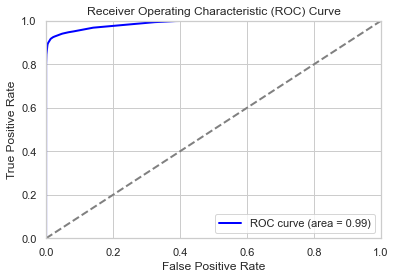

In [53]:
y_prob_lr = best_lr_model.predict_proba(X_test)[:, 1] # Predicting probabilities for the positive class

# Computing ROC AUC
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f'ROC AUC: {roc_auc:.2f}')

# Computing ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [59]:

best_params = {'fit_intercept': True, 'max_iter': 300, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.0001}
b_lr_model = LogisticRegression(**best_params, class_weight='balanced')

start_time = time.time() # start time
b_lr_model.fit(X_train, y_train) #Training
end_time = time.time() #  end time

####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")

######################################################
test_start_time = time.time() # Testing start time

y_pred_blr = b_lr_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing start time
########################################################

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

print("Accuracy:", accuracy_score(y_test, y_pred_blr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_blr))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_blr))

The training took 14.06 seconds
The testing took 0.00 seconds
Accuracy: 0.7940794311096786

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83     49639
           1       1.00      0.59      0.74     49642

    accuracy                           0.79     99281
   macro avg       0.85      0.79      0.78     99281
weighted avg       0.85      0.79      0.78     99281


Confusion Matrix:
[[49639     0]
 [20444 29198]]


C:\Users\A\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ROC AUC: 0.77


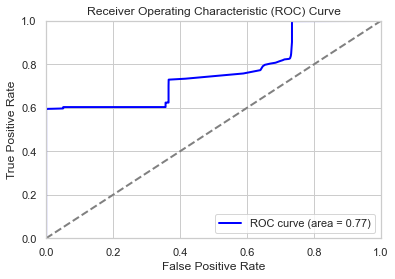

In [60]:
y_prob_lr = b_lr_model.predict_proba(X_test)[:, 1] # Predicting probabilities for the positive class

# Computing ROC AUC
roc_auc = roc_auc_score(y_test, y_prob_lr)
print(f'ROC AUC: {roc_auc:.2f}')

# Computing ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [54]:
 ##---------------3--Decision Tree -----------------##

In [55]:

########################################
dt_param_grid = {
   'criterion': ['gini', 'entropy'],
   'splitter': ['best', 'random'],
   'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
   'max_features': [None, 'sqrt', 'log2'],
   'max_leaf_nodes': [None, 10, 20, 30],
   'min_impurity_decrease': [0.0, 0.01, 0.1]
}
#########################################

dt_model = DecisionTreeClassifier(random_state=42) 

grid_search = GridSearchCV(dt_model, param_grid=dt_param_grid, cv=2, scoring = 'accuracy',  n_jobs=-1, verbose=2) # Initializing GridSearchCV

start_time = time.time() # Training start time

grid_search.fit(X_train, y_train) # Fitting GridSearchCV

end_time = time.time() # Training end time
####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")

best_dt_model = grid_search.best_estimator_ # Getting the best model from GridSearchCV

test_start_time = time.time() # Testing start time

y_pred_dt = best_dt_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing end time

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

########################################################
#Best parameters &&& Best estimator
print("Best parameters found: ", grid_search.best_params_)
print ("Best estimator : ", grid_search.best_estimator_)
########################################################

# Model Evaluation Metrics

print("accuracy")
print(accuracy_score(y_test, y_pred_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Fitting 2 folds for each of 5184 candidates, totalling 10368 fits
The training took 74.98 seconds
The testing took 0.01 seconds
Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'best'}
Best estimator :  DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)
accuracy
0.9520049153413039

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     49639
           1       0.98      0.92      0.95     49642

    accuracy                           0.95     99281
   macro avg       0.95      0.95      0.95     99281
weighted avg       0.95      0.95      0.95     99281


Confusion Matrix:
[[48624  1015]
 [ 3750 45892]]


In [51]:
###DT with best params

In [61]:

best_params = {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
               'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'best'}

b_dt_model = DecisionTreeClassifier(**best_params)

start_time = time.time() # Training start time
b_dt_model.fit(X_train, y_train) #Training
end_time = time.time() # Training end time

####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")

######################################################
test_start_time = time.time() # Testing start time

y_pred_bdt = b_dt_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing start time
########################################################

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

print("Accuracy:", accuracy_score(y_test, y_pred_bdt))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bdt))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_bdt))
#Saving the model
joblib.dump(b_dt_model, 'decision_tree_model.pkl') 
print("Model saved successfully as 'decision_tree_model.pkl'")

The training took 0.13 seconds
The testing took 0.01 seconds
Accuracy: 0.9520049153413039

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     49639
           1       0.98      0.92      0.95     49642

    accuracy                           0.95     99281
   macro avg       0.95      0.95      0.95     99281
weighted avg       0.95      0.95      0.95     99281


Confusion Matrix:
[[48624  1015]
 [ 3750 45892]]
Model saved successfully as 'decision_tree_model.pkl'


ROC AUC: 0.99


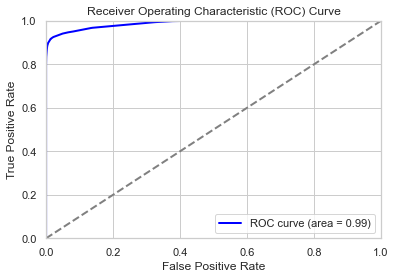

In [62]:
y_prob_bdt = b_dt_model.predict_proba(X_test)[:, 1] # Predicting probabilities for the positive class


roc_auc = roc_auc_score(y_test, y_prob_bdt) # Computing ROC AUC
print(f'ROC AUC: {roc_auc:.2f}')

fpr, tpr, _ = roc_curve(y_test, y_prob_bdt) # Computing ROC curve

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
path = '/Users/A/Documents/TEP/Figures/NN-ROCAUC.png'
plt.savefig(path, bbox_inches='tight')
plt.show()

In [57]:
##################### Gradient Boosting Classifier###################################

In [58]:

########################################
gbc_param_grid = {
   'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
#########################################

gbc_model = GradientBoostingClassifier(random_state=42) 
grid_search = GridSearchCV(estimator=gbc_model, param_grid=gbc_param_grid, cv=5, n_jobs=-1, verbose=2) # Initializing GridSearchCV

start_time = time.time() # Training start time

grid_search.fit(X_train, y_train) # Fitting GridSearchCV

end_time = time.time() # Training end time
####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")
    
best_gbc_model = grid_search.best_estimator_ # Getting the best model from GridSearchCV

test_start_time = time.time() # Testing start time

y_pred_gbc = best_gbc_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing start time

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

########################################################
#Best parameters &&& Best Estimator
print("Best parameters found: ", grid_search.best_params_)
print("Best estimator: ", grid_search.best_estimator_)
########################################################

# Model Evaluation Metrics

print("accuracy")
print(accuracy_score(y_test, y_pred_gbc))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gbc))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbc))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
The training took 3051.20 seconds
The testing took 0.55 seconds
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best estimator:  GradientBoostingClassifier(max_depth=5, min_samples_split=10, n_estimators=300,
                           random_state=42)
accuracy
0.9520452050241235

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     49639
           1       0.98      0.92      0.95     49642

    accuracy                           0.95     99281
   macro avg       0.95      0.95      0.95     99281
weighted avg       0.95      0.95      0.95     99281


Confusion Matrix:
[[48621  1018]
 [ 3743 45899]]


In [63]:
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}

b_gb_model = GradientBoostingClassifier(**best_params)

start_time = time.time() # Training start time
b_gb_model.fit(X_train, y_train) #Training
end_time = time.time() # Training end time

####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")

######################################################
test_start_time = time.time() # Testing start time

y_pred_bgb = b_gb_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing start time
########################################################

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

print("Accuracy:", accuracy_score(y_test, y_pred_bgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bgb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_bgb))

The training took 48.89 seconds
The testing took 0.52 seconds
Accuracy: 0.9520452050241235

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     49639
           1       0.98      0.92      0.95     49642

    accuracy                           0.95     99281
   macro avg       0.95      0.95      0.95     99281
weighted avg       0.95      0.95      0.95     99281


Confusion Matrix:
[[48621  1018]
 [ 3743 45899]]


ROC AUC: 0.99


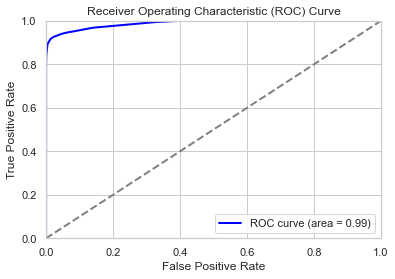

In [64]:
y_prob_bgb = b_gb_model.predict_proba(X_test)[:, 1] # Predicting probabilities for the positive class

# Computing ROC AUC
roc_auc = roc_auc_score(y_test, y_prob_bgb)
print(f'ROC AUC: {roc_auc:.2f}')

# Computing ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_bgb)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [60]:
############ Extreme Gradient Boosting model ############

In [61]:

########################################
xgboost_param_grid = {
   'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}
#########################################

xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') 
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=xgboost_param_grid, cv=5, n_jobs=-1, verbose=2) # Initializing GridSearchCV

start_time = time.time() # Training start time

grid_search.fit(X_train, y_train) # Fitting GridSearchCV

end_time = time.time() # Training end time
####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")
    
best_xgboost_model = grid_search.best_estimator_ # Getting the best model from GridSearchCV

test_start_time = time.time() # Testing start time

y_pred_xgboost = best_xgboost_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing start time

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

########################################################
#Best parameters &&& Best Estimator
print("Best parameters found: ", grid_search.best_params_)
print("Best estimator: ", grid_search.best_estimator_)
########################################################

# Model Evaluation Metrics

print("accuracy")
print(accuracy_score(y_test, y_pred_xgboost))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgboost))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgboost))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
The training took 1252.83 seconds
The testing took 0.03 seconds
Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, ...)
accuracy
0.952035

In [65]:
best_params = {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
b_xgb_model = XGBClassifier(**best_params, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_leaves=0,
              min_child_weight=1, monotone_constraints='()',
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1)

start_time = time.time() # Training start time
b_xgb_model.fit(X_train, y_train) #Training
end_time = time.time() # Training end time

####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")

######################################################
test_start_time = time.time() # Testing start time

y_pred_bxgb = b_xgb_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing start time
########################################################

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

print("Accuracy:", accuracy_score(y_test, y_pred_bxgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bxgb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_bxgb))

The training took 18.98 seconds
The testing took 0.04 seconds
Accuracy: 0.9520351326034185

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     49639
           1       0.98      0.92      0.95     49642

    accuracy                           0.95     99281
   macro avg       0.95      0.95      0.95     99281
weighted avg       0.95      0.95      0.95     99281


Confusion Matrix:
[[48624  1015]
 [ 3747 45895]]


ROC AUC: 0.99


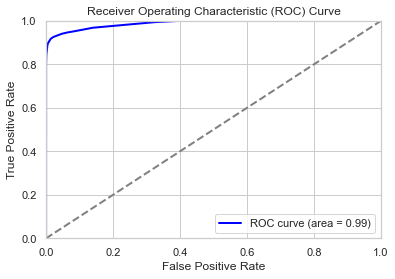

In [66]:
y_prob_bxgb = b_xgb_model.predict_proba(X_test)[:, 1] # Predicting probabilities for the positive class

# Computing ROC AUC
roc_auc = roc_auc_score(y_test, y_prob_bxgb)
print(f'ROC AUC: {roc_auc:.2f}')

# Computing ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_bxgb)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [62]:
##################################### MLPClassifier ######################################################

In [104]:

########################################
mlp_param_grid = {
    'hidden_layer_sizes': [(50, 50), (100,), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}
#########################################


mlp_model=MLPClassifier(random_state=42, max_iter=200)

mlp_grid_search = GridSearchCV(mlp_model, param_grid=mlp_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2) # Initializing GridSearchCV

start_time = time.time() # Training start time
mlp_grid_search.fit(X_train, y_train) # Fitting GridSearchCV
end_time = time.time() # Training end time

####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")

best_mlp_model = mlp_grid_search.best_estimator_ # Getting the best model from GridSearchCV

test_start_time = time.time() # Testing start time

y_pred_mlp = best_mlp_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing start time

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

########################################################
# Best parameters#
print("Best parameters found: ", mlp_grid_search.best_params_)

########################################################

# Model Evaluation Metrics

print("accuracy")
print(accuracy_score(y_test, y_pred_mlp))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\A\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


The training took 3551.45 seconds
The testing took 0.20 seconds
Best parameters found:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
accuracy
0.8854362869028314

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     49639
           1       0.96      0.80      0.88     49642

    accuracy                           0.89     99281
   macro avg       0.90      0.89      0.88     99281
weighted avg       0.90      0.89      0.88     99281


Confusion Matrix:
[[48098  1541]
 [ 9833 39809]]


In [67]:
best_params = {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50),
               'learning_rate': 'constant', 'solver': 'adam'}

b_mlp_model = MLPClassifier(**best_params)

start_time = time.time() # Training start time
b_mlp_model.fit(X_train, y_train) 
end_time = time.time() # Training end time

####################################

elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds")

######################################################
test_start_time = time.time() # Testing start time

y_pred_bmlp = b_mlp_model.predict(X_test) # Predicting on the test set

test_end_time = time.time() # Testing end time
########################################################

testing_elapsed_time = test_end_time - test_start_time

print(f"The testing took {testing_elapsed_time:.2f} seconds")

print("Accuracy:", accuracy_score(y_test, y_pred_bmlp))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bmlp))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_bmlp))

The training took 210.05 seconds
The testing took 0.20 seconds
Accuracy: 0.8129148578277817

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.63      0.77     49639
           1       0.73      0.99      0.84     49642

    accuracy                           0.81     99281
   macro avg       0.86      0.81      0.81     99281
weighted avg       0.86      0.81      0.81     99281


Confusion Matrix:
[[31319 18320]
 [  254 49388]]


In [64]:
######################## Neural Network ###################################

In [68]:

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(
            optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
            loss='binary_crossentropy', 
            metrics=['accuracy']
        )
        return model

hypermodel = MyHyperModel()

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='hyps_tuning',  
    project_name='bin_classification' 
)

tuner.search_space_summary()
start_time_tuning = time.time() # Tuning Time
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
end_time_tuning = time.time()

elapsed_time_tuning = end_time_tuning - start_time_tuning
print(f"The hyperparameter tuning took {elapsed_time_tuning:.2f} seconds")

# Getting the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

gc.collect()
tf.keras.backend.clear_session()

# the best model
best_model = hypermodel.build(best_hps)
#epochs = best_hps.get('epochs')
#batch_size = best_hps.get('batch_size')

start_time_training = time.time()  # the training time for the best model
history = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
end_time_training = time.time()

elapsed_time_training = end_time_training - start_time_training
print(f"The training took {elapsed_time_training:.2f} seconds")

# Evaluation on test set
test_start_time = time.time()
y_pred_prob_nn = best_model.predict(X_test)
y_pred_nn = (y_pred_prob_nn > 0.5).astype("int32")
test_end_time = time.time()

testing_elapsed_time = test_end_time - test_start_time
print(f"The testing took {testing_elapsed_time:.2f} seconds")

# Model Evaluation Metrics
print("accuracy")
print(accuracy_score(y_test, y_pred_nn))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))


Trial 5 Complete [00h 17m 31s]
val_accuracy: 0.7999323805173238

Best val_accuracy So Far: 0.8070982098579407
Total elapsed time: 04h 30m 34s
The hyperparameter tuning took 16234.47 seconds
Best hyperparameters: {'dropout_rate': 0.3, 'learning_rate': 0.0032782554287141517}
Epoch 1/20
5792/5792 [==============================] - 35s 6ms/step - loss: 0.4630 - accuracy: 0.7918 - val_loss: 0.2938 - val_accuracy: 0.7960
Epoch 2/20
5792/5792 [==============================] - 34s 6ms/step - loss: 0.3007 - accuracy: 0.8028 - val_loss: 0.2820 - val_accuracy: 0.8018
Epoch 3/20
5792/5792 [==============================] - 34s 6ms/step - loss: 0.2910 - accuracy: 0.8049 - val_loss: 0.2810 - val_accuracy: 0.8063
Epoch 4/20
5792/5792 [==============================] - 35s 6ms/step - loss: 0.2897 - accuracy: 0.8059 - val_loss: 0.2829 - val_accuracy: 0.8062
Epoch 5/20
5792/5792 [==============================] - 35s 6ms/step - loss: 0.2897 - accuracy: 0.8064 - val_loss: 0.2860 - val_accuracy: 0.8037
E

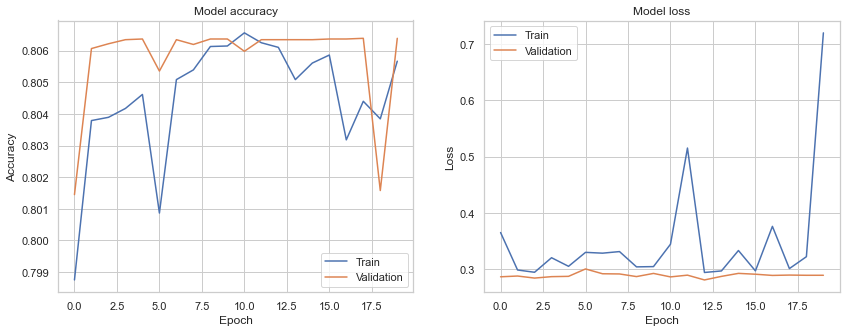

In [117]:
#  training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
path = '/Users/A/Documents/TEP/Figures/NN-accuracyloss score.png'
plt.savefig(path, bbox_inches='tight')
plt.show()


ROC AUC: 0.92


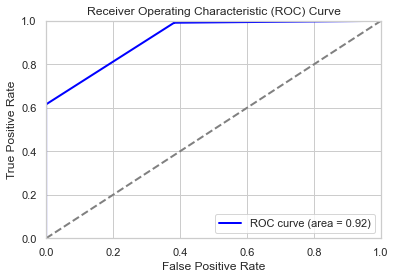

In [72]:

# Computing ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob_nn)
print(f'ROC AUC: {roc_auc:.2f}')

# Computing ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_nn)

# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

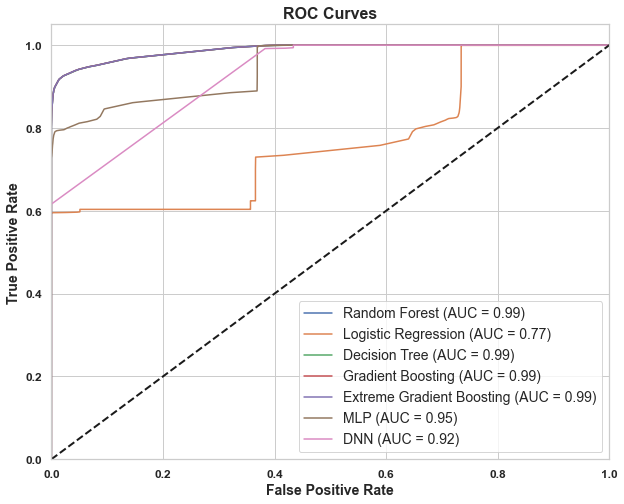

In [70]:
y_prob_brf = b_rf_model.predict_proba(X_test)[:, 1]
y_prob_blr = b_lr_model.predict_proba(X_test)[:, 1]
y_prob_bmlp = b_mlp_model.predict_proba(X_test)[:, 1] 

results = {}
y_probs = {
    'Random Forest': y_prob_brf,
    'Logistic Regression': y_prob_blr,
    'Decision Tree': y_prob_bdt,
    'Gradient Boosting': y_prob_bgb ,
    'Extreme Gradient Boosting': y_prob_bxgb,
    'MLP': y_prob_bmlp,
    'DNN': y_pred_prob_nn
}

#ROC AUC and ROC curve values
for name, y_prob in y_probs.items():
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    results[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

# all models ROC 
plt.figure(figsize=(10, 8))

for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curves', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')  
plt.yticks(fontsize=12, fontweight='bold') 
plt.legend(loc="lower right", fontsize=14) 

path = '/Users/A/Documents/TEP/Figures/DPI/Binary_all_ROC.png' 
plt.savefig(path, bbox_inches='tight', dpi=300)
plt.show()
